In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from motor.motor_asyncio import AsyncIOMotorClient
from pymongo.server_api import ServerApi
import numpy as np
import sklearn.cross_decomposition

import sp_project.db_access.db_access_entsoe as entsoeData
import sp_project.db_access.db_access_openweather as openweatherData
import sp_project.db_access.db_access_wetter2 as wetter2Data

%matplotlib inline

/Users/missd/.pyenv/versions/3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
df_energy_raw = await entsoeData.extract_energy_data_raw()
df_energy_daily = await entsoeData.extract_energy_data_daily()
df_weather_daily = await wetter2Data.extract_data_daily()
df_heating_demand = await wetter2Data.extract_heatingdemand()
df_windpower = await wetter2Data.extract_windpower()

In [4]:
input_features = []
input_features.append(df_heating_demand)
input_features.append(df_windpower)
input_features.append(df_weather_daily)
input_features = pd.concat(input_features, axis="columns")
input_features.head()

,avg_demand,windpower,temp_C,min_temp_C,max_temp_C,rain_mm,wind_kmh,cloud_percent
date,,,,,,,,
2019-01-01 00:00:00+00:00,13.898214,29.261071,0.101786,-8.8,7.4,0.000595,4.626190,27.797619
2019-01-02 00:00:00+00:00,18.281250,215.258229,-4.281250,-12.4,1.8,0.410417,13.486458,60.739583
2019-01-03 00:00:00+00:00,22.073958,99.923646,-8.073958,-16.4,1.7,0.042708,8.646875,32.354167
2019-01-04 00:00:00+00:00,21.297917,56.707292,-7.297917,-15.8,2.1,0.028125,6.416667,37.322917
2019-01-05 00:00:00+00:00,18.512500,79.278229,-4.512500,-11.2,1.7,0.567708,7.363542,62.072917


In [5]:
target_features = await entsoeData.extract_energy_data_daily()
target_features.head()

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
date,,,,,,,
2022-01-01 00:00:00+00:00,6.666667,77.458333,3022.791667,177.708333,249.458333,153.916667,3688.000000
2022-01-02 00:00:00+00:00,36.250000,59.083333,3019.208333,164.375000,238.041667,151.041667,3668.000000
2022-01-03 00:00:00+00:00,39.000000,34.750000,3008.458333,189.541667,228.583333,573.166667,4073.500000
2022-01-04 00:00:00+00:00,47.416667,59.583333,2999.125000,275.583333,211.333333,517.041667,4110.083333
2022-01-05 00:00:00+00:00,24.208333,99.916667,3023.958333,401.500000,216.208333,1055.000000,4820.791667


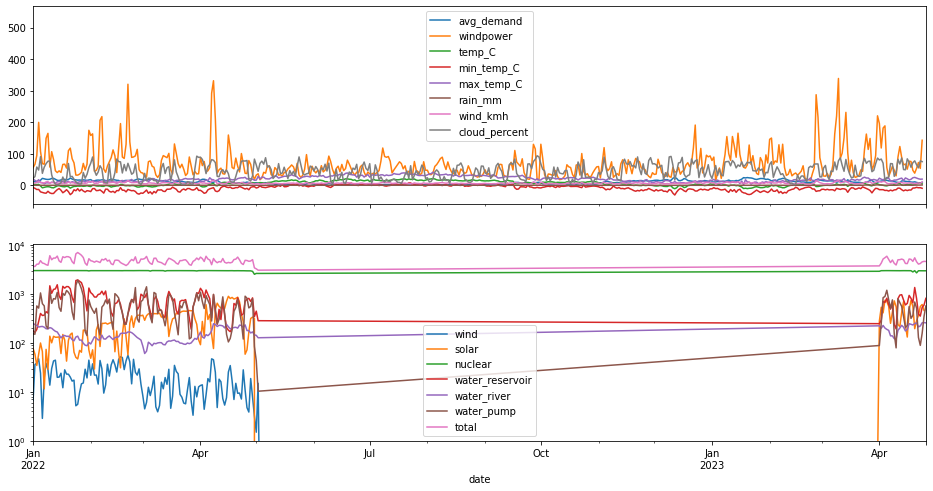

In [6]:
fig,axes = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features.plot(ax=ax)
ax = axes[1]
target_features.plot(ax=ax)
ax.set_yscale("log")

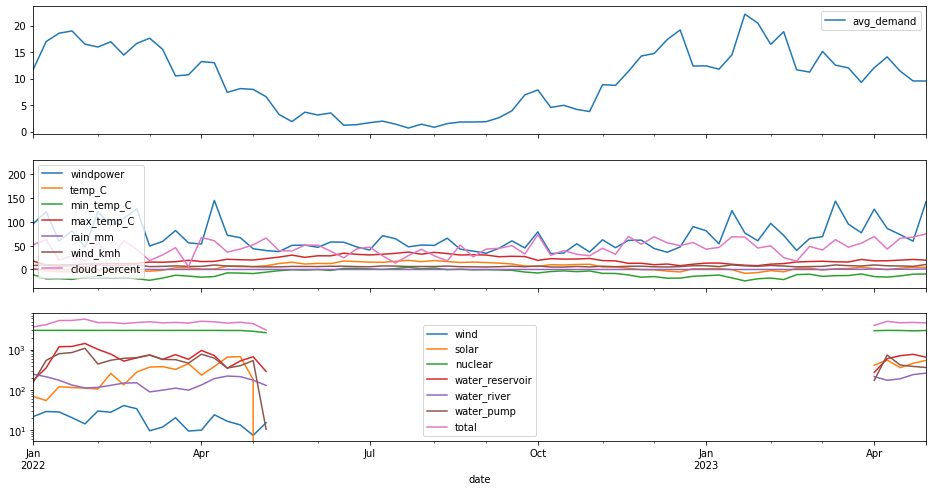

In [7]:
fig,axes = plt.subplots(3,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features.iloc[:,:1].resample('W').mean().plot(ax=ax)
ax = axes[1]
input_features.iloc[:,1:].resample('W').mean().plot(ax=ax)
ax = axes[2]
target_features.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")

In [8]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

valid_input_features_ts = input_features_weekly.dropna(axis="index", how='any').index
valid_target_features_ts = target_features_weekly.dropna(axis="index", how='any').index

joined_index = valid_input_features_ts.intersection(valid_target_features_ts)



pls2 = sklearn.cross_decomposition.PLSRegression(n_components=2)

# Data for prediction (fitter can not use the columns-name, so we use seperate variables)
input_features_columns = input_features_weekly.columns
target_features_columns = target_features_weekly.columns
pls2 = pls2.fit(
    input_features_weekly.loc[joined_index,:], 
    target_features_weekly.loc[joined_index,:],
)

In [9]:
Y_pred = pls2.predict(input_features.loc[:,input_features_columns])
Y_pred = pd.DataFrame(Y_pred, index = input_features.index,columns=target_features_columns)
Y_pred

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
date,,,,,,,
2019-01-01 00:00:00+00:00,15.104394,244.777207,2968.763630,882.944903,108.739379,706.527216,4952.662213
2019-01-02 00:00:00+00:00,33.259567,224.917801,3134.445710,609.764801,226.993664,533.219953,4704.053131
2019-01-03 00:00:00+00:00,31.319034,125.074565,3097.701724,996.699652,120.433086,872.092688,5249.967440
2019-01-04 00:00:00+00:00,27.104717,134.204360,3060.086102,1044.254827,97.146261,898.121890,5284.655450
2019-01-05 00:00:00+00:00,23.505415,219.971199,3042.515154,811.323386,149.075434,675.394338,4917.160943
...,...,...,...,...,...,...,...
2023-04-20 00:00:00+00:00,3.948969,415.317329,2896.518764,495.291062,181.922936,315.563109,4298.961646
2023-04-21 00:00:00+00:00,4.451793,423.839229,2902.801014,455.897294,193.554247,282.261745,4245.870306
2023-04-22 00:00:00+00:00,6.802110,403.390720,2920.912377,483.253568,192.396074,315.992233,4304.741623


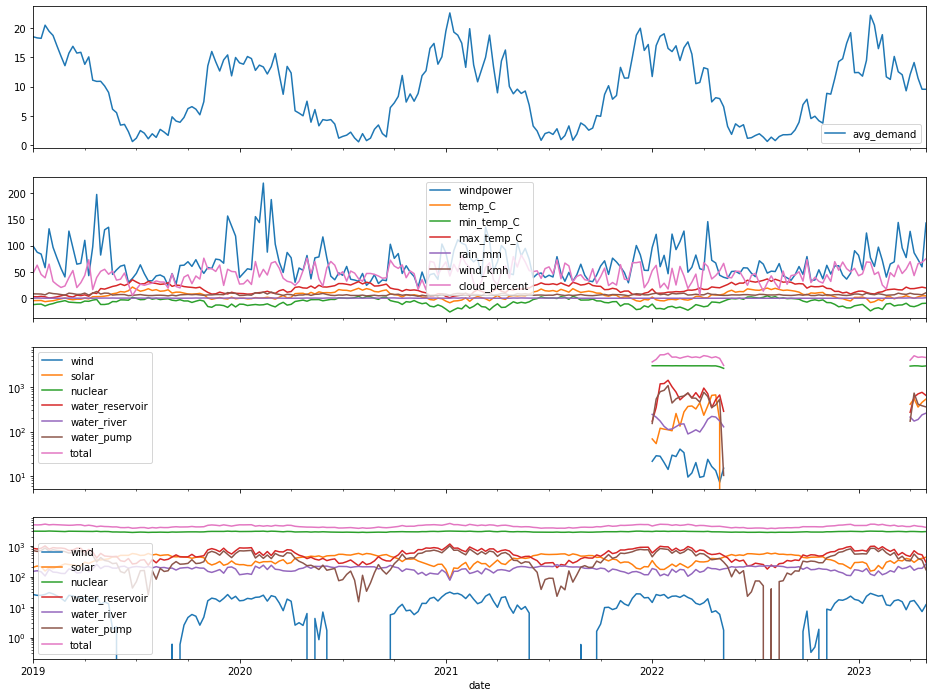

In [10]:
fig,axes = plt.subplots(4,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_features.iloc[:,:1].resample('W').mean().plot(ax=ax)
ax = axes[1]
input_features.iloc[:,1:].resample('W').mean().plot(ax=ax)
ax = axes[2]
target_features.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")
ax = axes[3]
Y_pred.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")